In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import pandas as pd
import random

In [2]:
sns.set_context("notebook", font_scale=1.25)

# 1 Fitting IRF3 data

In [3]:
path = "C:/Users/u163769/Desktop/PhD - virus project/Experimental_data_v1"

In [4]:
# Loading the raw data with which we want to reproduce the threshold-linear
data_chx_3hpi = pd.read_csv(str(path)+'/CHX_3hpi.txt', sep=",", header=None)
data_chx_3hpi.columns = ["IRF3", "RIG-I"]

## 1a Replicating threshold linear response

In [5]:
def process_and_plot_CHX(dataframe, window_size=100, overlap_step=5, theta=4000):
    
    # Step 1: Sort the DataFrame by the 'RIG-I' column and reset the index
    dataframe_sorted = dataframe.sort_values(by='RIG-I').reset_index(drop=True)

    # Step 2: Extract overlapping DataFrames with a custom window size and overlap step
    overlapping_dataframes = []
    for i in range(0, len(dataframe_sorted) - window_size + 1, overlap_step):
        df_slice = dataframe_sorted.iloc[i:i + window_size]
        overlapping_dataframes.append(df_slice)

    # Calculate mean values and percentage of cells above the threshold for each generated DataFrame
    result_list = []

    for idx, df in enumerate(overlapping_dataframes):
        mean_rig = df['RIG-I'].mean()
        percentage_irf3_above_theta = (df['IRF3'] > theta).mean() * 100

        result = {'DataFrame': idx + 1, 'Mean RIG-I': mean_rig, 'Percentage IRF3 Above Theta': percentage_irf3_above_theta}
        result_list.append(result)

        print(f"\nDataFrame {idx + 1} Results:")
        print(f"Total cells in the bin (dataframe): {len(df)}")
        print(f"Mean RIG-I Value: {mean_rig}")
        print(f"Percentage of IRF3 Values Above Theta ({theta}): {percentage_irf3_above_theta:.2f}%")

    # Convert results to DataFrame
    result_df = pd.DataFrame(result_list)

    # Plot mean RIG-I values and percentage of IRF3 values above threshold as a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(result_df['Mean RIG-I'], result_df['Percentage IRF3 Above Theta'], label='Scatter Plot')

    plt.xlabel('Mean RIG-I Values')
    plt.ylabel(f' % of cells with IRF3 Above {theta}')
    plt.title(f'Mean RIG-I vs Percentage of IRF3 Above {theta}', pad = 10)
    plt.show()
    return result_df


DataFrame 1 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 380.03926076675225
Percentage of IRF3 Values Above Theta (4000): 1.98%

DataFrame 2 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 386.74230918095157
Percentage of IRF3 Values Above Theta (4000): 1.98%

DataFrame 3 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 392.4866531181482
Percentage of IRF3 Values Above Theta (4000): 1.98%

DataFrame 4 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 397.6201433936213
Percentage of IRF3 Values Above Theta (4000): 2.97%

DataFrame 5 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 402.41067891578194
Percentage of IRF3 Values Above Theta (4000): 3.96%

DataFrame 6 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 407.0138930870009
Percentage of IRF3 Values Above Theta (4000): 3.96%

DataFrame 7 Results:
Total cells in the bin (dataframe): 101
Mean RIG-I Value: 411.4320903862855

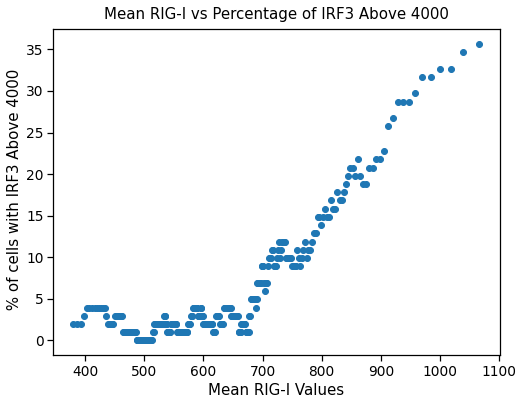

In [6]:
result_df_chx = process_and_plot_CHX(data_chx_3hpi, window_size=101, overlap_step=5, theta=4000)

## 1b Fitting virus distribution

In [7]:
data_chx_6hpi = pd.read_csv(str(path)+'/CHX_RNA_6hpi.txt', sep=",", header=None)
data_chx_6hpi.columns = ["mRNA+", "IFN", "RIG-I"]

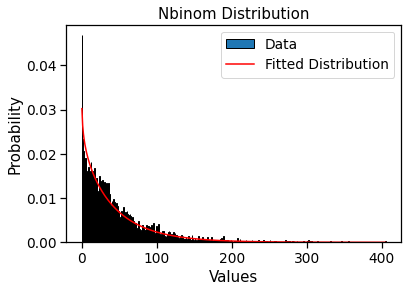

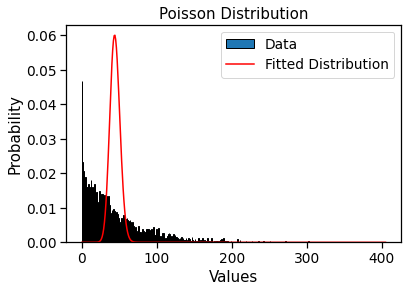

C:\Users\u163769\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:941: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


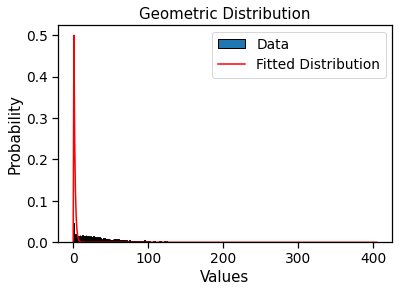

Nbinom Distribution:
Log Likelihood: -21717.9700
Optimal Parameters: [0.89280674 0.01984062]

Poisson Distribution:
Log Likelihood: -102285.5976
Optimal Parameters: [44.10615234]

Geometric Distribution:
Log Likelihood: -inf
Optimal Parameters: [0.5]



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, poisson, geom
from scipy.optimize import minimize

# Load your discrete data
data = list(data_chx_6hpi["mRNA+"])
x = pd.Series(data)
log_likelihoods = {}  # we'll use it later

# Negative log likelihood function for a distribution
def neg_log_likelihood(params, x, distribution):
    return -np.sum(distribution.logpmf(x, *params))

# Fit different distributions to the data
distributions = {
    'nbinom': nbinom,
    'poisson': poisson,
    'geometric': geom
}

# Results dictionary to store log likelihoods and optimal parameters
results = {}

for distribution_name, distribution in distributions.items():
    # Initial guess for distribution parameters
    if distribution_name == 'nbinom':
        # Specify initial guess for nbinom parameters (r, p)
        initial_params = [1.0, 0.5]
    elif distribution_name == 'poisson':
        # Specify initial guess for poisson parameters (lambda_)
        initial_params = [1.0]
    elif distribution_name == 'geometric':
        # Specify initial guess for geometric parameters (p)
        initial_params = [0.5]
    else:
        raise ValueError("Invalid distribution")

    # Optimize the negative log likelihood function
    result = minimize(neg_log_likelihood, initial_params, args=(x, distribution), method='Nelder-Mead')
    
    # Get the optimized parameters
    optimal_params = result.x
    
    # Calculate the log likelihood
    log_likelihood = -result.fun
    
    # Store results
    results[distribution_name] = {'log_likelihood': log_likelihood, 'optimal_params': optimal_params}
    
    # Plot the histogram and the fitted distribution
    plt.hist(data, bins=np.arange(min(data) - 0.5, max(data) + 1.5, 1), edgecolor='black', label='Data', density=True)
    
    x_values = np.arange(min(data), max(data) + 1)
    fitted_distribution = distribution(*optimal_params)
    plt.plot(x_values, fitted_distribution.pmf(x_values), 'r-', label='Fitted Distribution')
    
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(f'{distribution_name.capitalize()} Distribution')
    plt.legend()
    plt.show()

# Print results
for distribution_name, result in results.items():
    print(f"{distribution_name.capitalize()} Distribution:")
    print(f"Log Likelihood: {result['log_likelihood']:.4f}")
    print(f"Optimal Parameters: {result['optimal_params']}\n")


## 1c Fitting IRF3 data

In [10]:
def plotting_experimental_fitted_parameters(v, R_tot, IFN_percent, K1,K2, gamma, theta):
    # Calculating amount of active RIG-I
    V, R_TOT = np.meshgrid(v, R_tot)
    R_active = (V*R_TOT)/(gamma+V)   
    # Calculating IFN 
    alpha = 1
    n = 5
    nv = 3
    alpha = 1
    # 2. Calculation of IFN (or IRF3) concentration
    IRF3 = (alpha*(R_active**n))/(K1**n+R_active**n) + (alpha*(V**nv))/(K2**nv+V**nv)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, R_active, cmap="Purples")
    #ax.contour(CS, colors='black')
    ax.set_title('RIG-I*')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, IRF3, cmap="Blues")
    ax.set_title('IRF3 expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    # Calculating % of cells expressing IFN
    fraction_of_cells = []
    for i in range(len(R_tot)):
        cells = IRF3[i] 
        count = 0
        for element in cells:
            if element >= theta:
                count +=1
        fraction_of_cells.append(((count/len(R_tot))*100))
        
    plt.figure(figsize = (7,5))
    plt.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    plt.plot(R_tot,fraction_of_cells, 'or-', label= "Fitting")
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IRF3")
    plt.legend()
    plt.show()

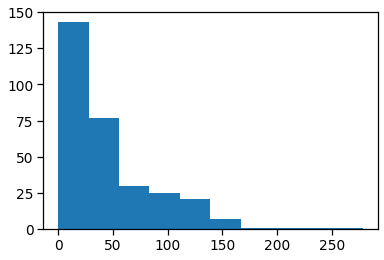

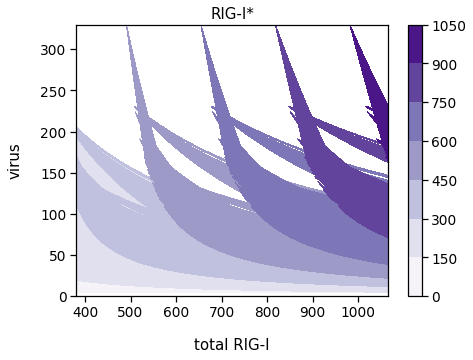

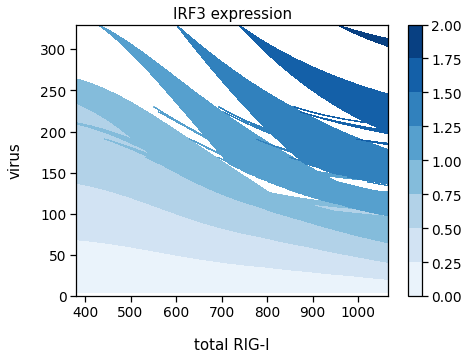

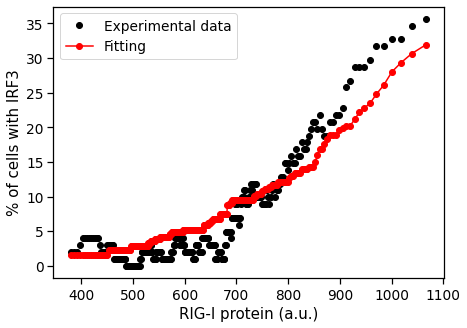

In [14]:
virus = np.random.negative_binomial(0.89280674, 0.01984062, 307)
plt.hist(virus)
RIG_values = result_df_chx["Mean RIG-I"].tolist() 
actual_IFN_percentage = result_df_chx["Percentage IRF3 Above Theta"].tolist()
plotting_experimental_fitted_parameters(virus1,RIG_values,actual_IFN_percentage, K1=630, K2=150, gamma=30,theta = 0.666)

In [15]:
def plotting_experimental_fitted_parameters(v, R_tot, IFN_percent, K1,K2, gamma, theta):
    # Calculating amount of active RIG-I
    V, R_TOT = np.meshgrid(v, R_tot)
    R_active = (V*R_TOT)/(gamma+V)   
    # Calculating IFN 
    alpha = 1
    n = 5
    nv = 3
    alpha = 1
    # 2. Calculation of IFN (or IRF3) concentration
    IRF3 = (alpha*(R_active**n))/(K1**n+R_active**n) + (alpha*(V**nv))/(K2**nv+V**nv)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, R_active, cmap="Purples")
    ax.set_title('RIG-I*')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, IRF3, cmap="Blues")
    ax.set_title('IRF3 expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    # Calculating % of cells expressing IFN
    fraction_of_cells = []
    for i in range(len(R_tot)):
        cells = IRF3[i] 
        count = 0
        for element in cells:
            if element >= theta:
                count +=1
        fraction_of_cells.append(((count/len(R_tot))*100))
    

    plt.figure(figsize = (7,5))
    plt.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    plt.plot(np.array(R_tot),np.array(fraction_of_cells), 'or-', label= "Fitting")
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IRF3")
    plt.legend()
    
    plt.figure(figsize = (10,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))

    # Plot data on subplots
    ax1.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(R_tot,fraction_of_cells, 'or-', label= "Fitting")

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IRF3')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Fitting")
    #plt.savefig('IRF3_fitting.pdf')
    
    
    
    the_indices = np.arange(0, len(R_tot), 8)
    print(the_indices)
    print(len(R_tot))
    plt.figure(figsize = (7,5))
    plt.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    #plt.figure(figsize = (7,5))
    plt.plot(np.array(R_tot)[the_indices],np.array(fraction_of_cells)[the_indices], 'r-', label= "Fitting", linewidth = 3)
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IRF3")
    plt.legend()
    #plt.savefig('IRF3_fitting.pdf')
    
    
    plt.figure(figsize = (10,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))

    # Plot data on subplots
    ax1.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(np.array(R_tot),np.array(fraction_of_cells), 'r-', label= "Fitting" , linewidth = 3)

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IRF3')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Model behaviour")
    #plt.savefig('IRF3_fitting.pdf')
    
    
    plt.show()

<class 'list'>
<class 'numpy.ndarray'>
[  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280
 288 296 304]
307


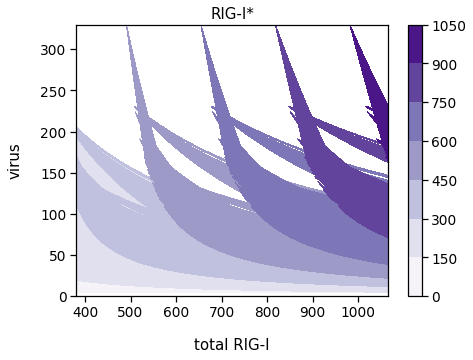

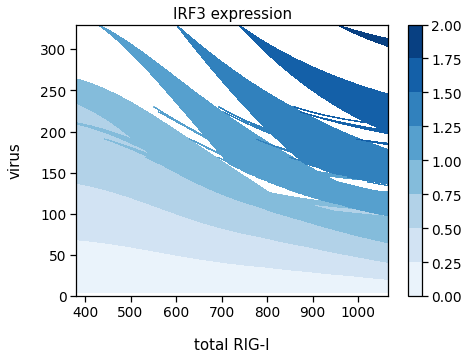

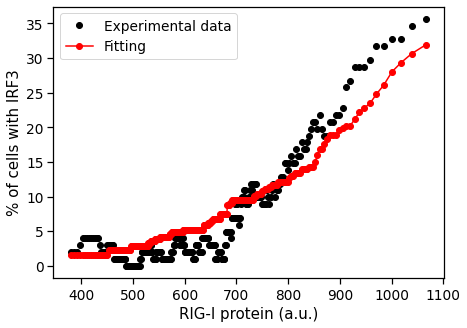

<Figure size 720x360 with 0 Axes>

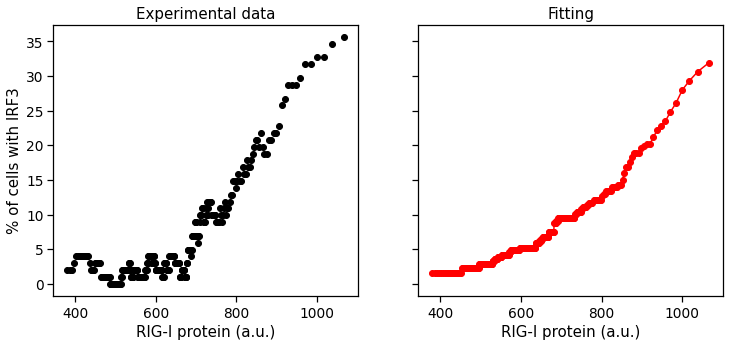

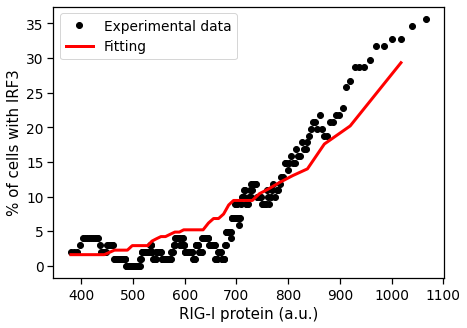

<Figure size 720x360 with 0 Axes>

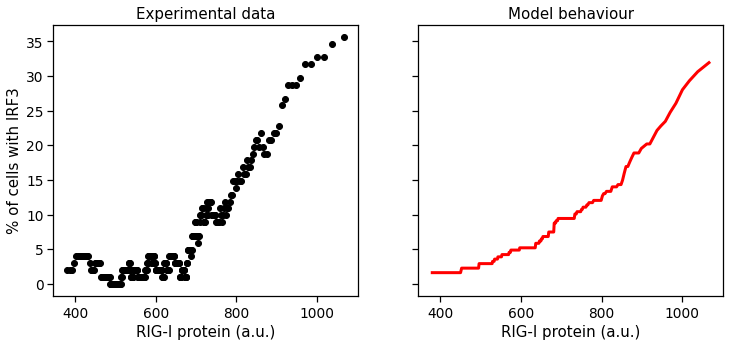

In [16]:
RIG_values = result_df_chx["Mean RIG-I"].tolist() 
actual_IFN_percentage = result_df_chx["Percentage IRF3 Above Theta"].tolist()
plotting_experimental_fitted_parameters(virus1,RIG_values,actual_IFN_percentage, K1=630, K2=150, gamma=30,theta = 0.666)

# 2 Fitting IFN CHX data 

In [17]:
path = "C:/Users/u163769/Desktop/PhD - virus project/Experimental_data_v1"

In [18]:
data_chx_6hpi_IFN = pd.read_csv(str(path)+'/CHX_RUX/240213_6hpi_CHX_NP_IFN_RIGprot.txt', sep=",", header=None)
data_chx_6hpi_IFN.columns = ["NPRNA", "IFN", "RIG-I"]

data_chx_6hpi_IFN

,NPRNA,IFN,RIG-I
0,92,3,789.174945
1,19,2,571.038605
2,95,3,406.434526
3,244,5,635.654497
4,87,5,673.182875
...,...,...,...
3467,55,2,308.285074
3468,88,9,389.011188
3469,150,196,1018.291809
3470,7,0,451.967388


## 2a Replicating threshold linear response

In [19]:
def process_and_plot_CHX(dataframe, window_size=100, overlap_step=5, theta=35):
    
    # Step 1: Sort the DataFrame by the 'RIG-I' column and reset the index
    dataframe_sorted = dataframe.sort_values(by='RIG-I').reset_index(drop=True)

    # Step 2: Extract overlapping DataFrames with a custom window size and overlap step
    overlapping_dataframes = []
    for i in range(0, len(dataframe_sorted) - window_size + 1, overlap_step):
        df_slice = dataframe_sorted.iloc[i:i + window_size]
        overlapping_dataframes.append(df_slice)

    # Calculate mean values and percentage of cells above the threshold for each generated DataFrame
    result_list = []

    for idx, df in enumerate(overlapping_dataframes):
        mean_rig = df['RIG-I'].mean()
        st_dev = df['RIG-I'].std()
        sd_norm = df['RIG-I'].std()/(df['RIG-I'].mean())

        # Calculate the first quartile (Q1)
        q1 = df['RIG-I'].quantile(0.25)
        # Calculate the third quartile (Q3)
        q3 = df['RIG-I'].quantile(0.75)
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        num_cells_ifn_above_theta = (df['IFN'] > theta).sum()
        percentage_IFN_above_theta = (df['IFN'] >= theta).mean() * 100

        result = {'DataFrame': idx + 1, 'Mean RIG-I': mean_rig, 'Percentage IFN Above Theta': percentage_IFN_above_theta, "SD": st_dev, "IQR": iqr, "SD_norm": sd_norm}
        result_list.append(result)

        print(f"\nDataFrame {idx + 1} Results:")
        print(f"Number of cells with IFN values above : {num_cells_ifn_above_theta}")
        print(f"Total cells in the bin (dataframe): {len(df)}")
        print(f"Mean RIG-I Value: {mean_rig}")
        print({df['RIG-I'].max()})
        print({df['RIG-I'].median()})

        print(f"Percentage of IFN Values Above Theta ({theta}): {percentage_IFN_above_theta:.2f}%")

    # Convert results to DataFrame
    result_df = pd.DataFrame(result_list)

    # Plot mean RIG-I values and percentage of IRF3 values above threshold as a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(result_df['Mean RIG-I'], result_df['Percentage IFN Above Theta'], label='Scatter Plot')

    plt.xlabel('Mean RIG-I Values')
    
  
    y_ticks = np.arange(0, 18.02, 2)
    plt.yticks(y_ticks)
    
    plt.ylabel(f' % of infected cells with IFN Above {theta}')
    plt.title(f'Mean RIG-I vs Percentage of IFN Above {theta}', pad = 10)
    plt.show()
    return result_df


DataFrame 1 Results:
Number of cells with IFN values above : 9
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 146.19135118760371
{277.949879565777}
{151.3996864425785}
Percentage of IFN Values Above Theta (35): 1.80%

DataFrame 2 Results:
Number of cells with IFN values above : 13
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 172.6444244294202
{294.397339821573}
{184.8006543029935}
Percentage of IFN Values Above Theta (35): 2.80%

DataFrame 3 Results:
Number of cells with IFN values above : 14
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 198.15237076447926
{304.491893850195}
{206.4701873797085}
Percentage of IFN Values Above Theta (35): 3.00%

DataFrame 4 Results:
Number of cells with IFN values above : 16
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 222.53390654357565
{321.484406878461}
{233.82005474611498}
Percentage of IFN Values Above Theta (35): 3.40%

DataFrame 5 Results:
Number of cells with IFN values above : 21
Total cells in t

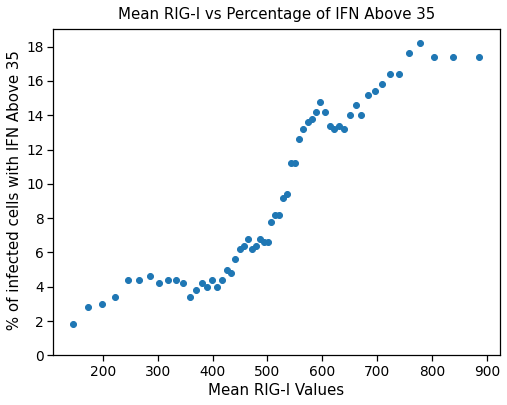

In [20]:
result_df_CHX_IFN = process_and_plot_CHX(data_chx_6hpi_IFN, window_size=500, overlap_step=50, theta=35)

## 2b Removing outliers for IFN CHX

In [22]:
def remove_outliers_std_dev(df, column_name, threshold=2):
    """
    Remove outliers from a DataFrame using the standard deviation method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column in the DataFrame to identify outliers.
    - threshold (float): Z-score threshold for identifying outliers. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame without outliers.
    """

    # Calculate mean and standard deviation
    mean_value = df[column_name].mean()
    std_dev = df[column_name].std()

    # Calculate z-scores for each data point
    df['Z_Score'] = (df[column_name] - mean_value) / std_dev

    # Identify and remove outliers
    df_no_outliers = df[abs(df['Z_Score']) <= threshold].copy()

    # Drop the temporary Z_Score column
    df_no_outliers.drop(columns=['Z_Score'], inplace=True)

    return df_no_outliers

In [23]:
result_df_CHX_IFN_no_outliers = remove_outliers_std_dev(result_df_CHX_IFN, 'SD_norm', threshold=2)

<AxesSubplot:xlabel='Mean RIG-I', ylabel='Percentage IFN Above Theta'>

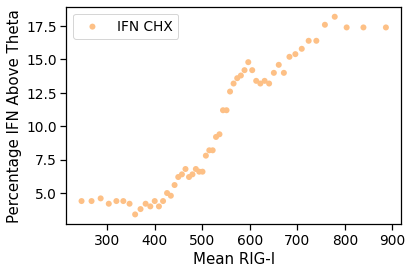

In [24]:
sns.scatterplot(x=result_df_CHX_IFN_no_outliers["Mean RIG-I"], y=result_df_CHX_IFN_no_outliers["Percentage IFN Above Theta"], edgecolor='none', color="#fdc086", label = "IFN CHX")

## 2c Fitting experimental data

In [36]:
def plotting_experimental_fitted_parameters(v, R_tot, IFN_percent, K1,K2,K3, gamma, theta):
    # Calculating amount of active RIG-I
    V, R_TOT = np.meshgrid(v, R_tot)

    R_active = (V*R_TOT)/(gamma+V) 
    
    # Calculating IFN 
    alpha = 1
    n = 5

    alpha = 1
    # 2. Calculation of IFN (or IRF3) concentration
    n = 5
    nv = 3
    IRF3 = (alpha*(R_active**n))/(K1**n+R_active**n) + (alpha*(V**nv))/(K2**nv+V**nv)

    
    # 2. Calculation of IFN (or IRF3) concentration
    alpha = 0.25 
    IFN = (alpha*(IRF3**n))/(K3**n+IRF3**n)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, R_active, cmap="Purples")
    ax.set_title('RIG-I*')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, IRF3, cmap="Blues")
    ax.set_title('IRF3 expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_TOT,V, IFN, cmap="Greens")
    ax.set_title('IFN expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    # Calculating % of cells expressing IFN
    fraction_of_cells = []
    for i in range(len(R_tot)):
        cells = IFN[i] 
        count = 0
        for element in cells:
            if element >= theta:
                count +=1
        fraction_of_cells.append(((count/len(R_tot))*100))
        
    plt.figure(figsize = (7,5))
    plt.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    plt.plot(R_tot,fraction_of_cells, 'or-', label= "Fitting")
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IFN")
    plt.savefig('IFN_CHX_fitting.pdf')
    plt.legend()
    
    
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))
    # Plot data on subplots
    ax1.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(R_tot,fraction_of_cells, 'or-', label= "Fitting")

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IFN')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Fitting")
    #plt.savefig('IFN_CHX_fitting.pdf')
    
    
    
    the_indices = np.arange(0, len(R_tot), 6)
    print(the_indices)
    print(the_indices)
    plt.figure(figsize = (7,5))
    plt.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    plt.plot(np.array(R_tot)[the_indices],np.array(fraction_of_cells)[the_indices], 'r-', label= "Fitting", linewidth=3)
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IRF3")
    plt.legend()
    #plt.savefig('IRF3_fitting.pdf')
    
    
    plt.figure(figsize = (10,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))

    # Plot data on subplots
    ax1.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(np.array(R_tot)[the_indices],np.array(fraction_of_cells)[the_indices], 'r-', label= "Fitting" , linewidth = 3)

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IRF3')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Model behaviour")
    #plt.savefig('IRF3_fitting.pdf')
    plt.ylim(0,25)
    plt.show()

[ 0  6 12 18 24 30 36 42 48 54]
[ 0  6 12 18 24 30 36 42 48 54]


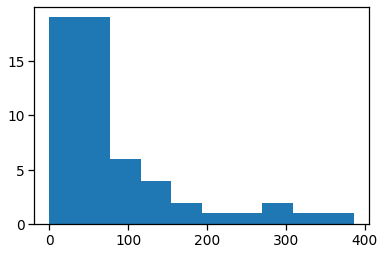

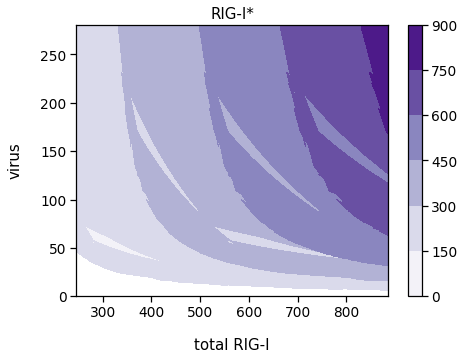

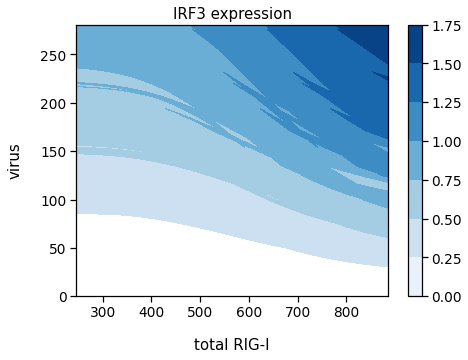

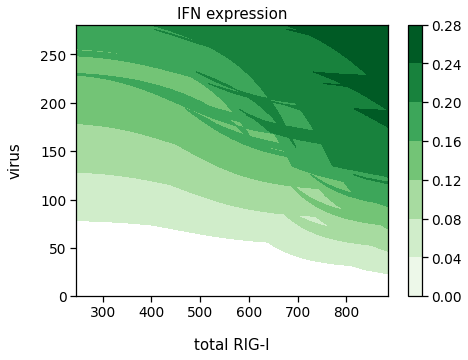

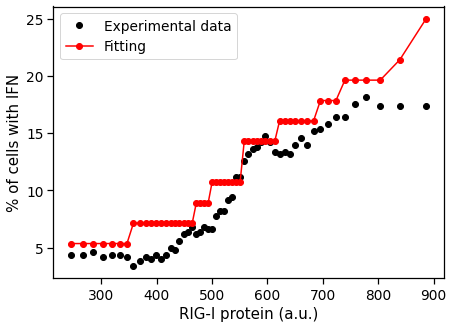

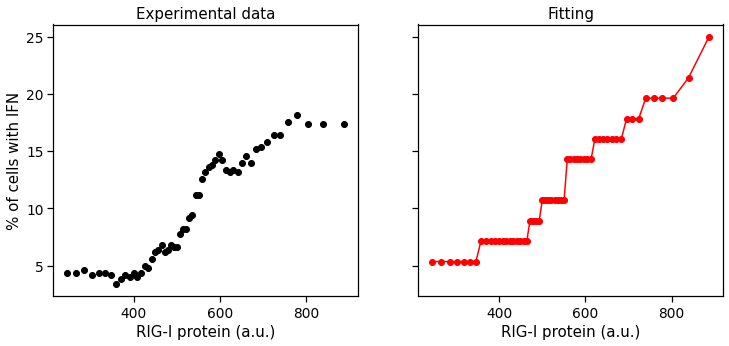

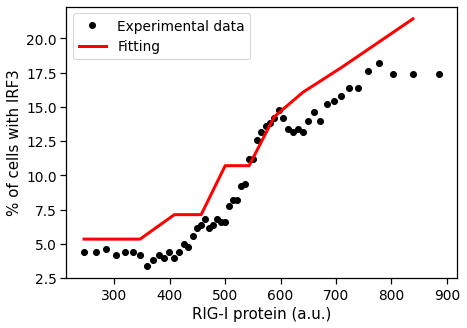

<Figure size 720x360 with 0 Axes>

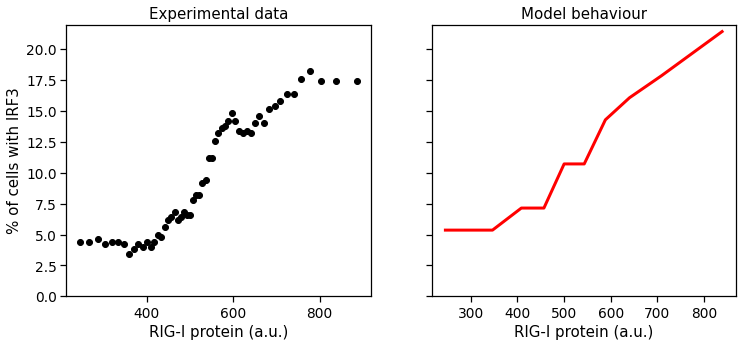

In [35]:
RIG_values = result_df_CHX_IFN_no_outliers["Mean RIG-I"].tolist()
actual_IFN_percentage = result_df_CHX_IFN_no_outliers["Percentage IFN Above Theta"].tolist()
virus = random.sample(list(data_chx_6hpi_IFN["NPRNA"]), len(RIG_values))
plotting_experimental_fitted_parameters(virus, RIG_values,actual_IFN_percentage, K1=630, K2=150, K3=0.7, gamma=30,theta=0.16)

# 3 Fitting IFN RUX data 

In [37]:
path = "C:/Users/u163769/Desktop/PhD - virus project/Experimental_data_v1/RUX"

In [38]:
data_rux_6hpi = pd.read_csv(str(path)+'/240102_6hpi_RUX_NP_IFN_RIGprot.txt', sep=",", header=None)
data_rux_6hpi.columns = ["NPRNA", "IFN", "RIG-I"]

In [39]:
data_rux_6hpi

,NPRNA,IFN,RIG-I
0,67,6,301.706557
1,205,0,297.366554
2,250,1,453.103091
3,29,3,357.324017
4,385,4,298.927817
...,...,...,...
10391,464,4,388.703433
10392,104,4,540.695710
10393,304,1,457.091485
10394,32,0,653.896397


## 3a Replicating threshold linear response

In [40]:
def process_and_plot_RUX(dataframe, window_size=100, overlap_step=5, theta=35):
    
    # Step 1: Sort the DataFrame by the 'RIG-I' column and reset the index
    dataframe_sorted = dataframe.sort_values(by='RIG-I').reset_index(drop=True)

    # Step 2: Extract overlapping DataFrames with a custom window size and overlap step
    overlapping_dataframes = []
    for i in range(0, len(dataframe_sorted) - window_size + 1, overlap_step):
        df_slice = dataframe_sorted.iloc[i:i + window_size]
        overlapping_dataframes.append(df_slice)

    # Calculate mean values and percentage of cells above the threshold for each generated DataFrame
    result_list = []

    for idx, df in enumerate(overlapping_dataframes):
        mean_rig = df['RIG-I'].mean()
        st_dev = df['RIG-I'].std()
        sd_norm = df['RIG-I'].std()/(df['RIG-I'].mean())
        # Calculate the first quartile (Q1)
        q1 = df['RIG-I'].quantile(0.25)
        # Calculate the third quartile (Q3)
        q3 = df['RIG-I'].quantile(0.75)
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        
        num_cells_ifn_above_theta = (df['IFN'] > theta).sum()
        percentage_IFN_above_theta = (df['IFN'] >= theta).mean() * 100

        result = {'DataFrame': idx + 1, 'Mean RIG-I': mean_rig, 'Percentage IFN Above Theta': percentage_IFN_above_theta, "SD": st_dev, "IQR": iqr, "SD_norm": sd_norm}
        result_list.append(result)

        print(f"\nDataFrame {idx + 1} Results:")
        print(f"Number of cells with IFN values above : {num_cells_ifn_above_theta}")
        print(f"Total cells in the bin (dataframe): {len(df)}")
        print(f"Mean RIG-I Value: {mean_rig}")
        print({df['RIG-I'].max()})
        print({df['RIG-I'].median()})

        print(f"Percentage of IFN Values Above Theta ({theta}): {percentage_IFN_above_theta:.2f}%")

    # Convert results to DataFrame
    result_df = pd.DataFrame(result_list)

    # Plot mean RIG-I values and percentage of IRF3 values above threshold as a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(result_df['Mean RIG-I'], result_df['Percentage IFN Above Theta'], label='Scatter Plot')

    plt.xlabel('Mean RIG-I Values')
    
    # Set custom tick marks for x-axis
    x_ticks = np.arange(200, 1201, 200)
    plt.xticks(x_ticks)
    
    y_ticks = np.arange(0, 14.01, 2)
    plt.yticks(y_ticks)
    
    plt.ylabel(f' % of infected cells with IFN Above {theta}')
    plt.title(f'Mean RIG-I vs Percentage of IFN Above {theta}', pad = 10)
    plt.show()
    return result_df



DataFrame 1 Results:
Number of cells with IFN values above : 1
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 257.4476790163219
{296.595005799277}
{265.464013062851}
Percentage of IFN Values Above Theta (35): 0.20%

DataFrame 2 Results:
Number of cells with IFN values above : 1
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 268.4975617295012
{301.875}
{273.14378748996}
Percentage of IFN Values Above Theta (35): 0.20%

DataFrame 3 Results:
Number of cells with IFN values above : 1
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 276.723326548088
{306.587703016241}
{280.84735867522204}
Percentage of IFN Values Above Theta (35): 0.20%

DataFrame 4 Results:
Number of cells with IFN values above : 1
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 283.781735857018
{310.149678293261}
{286.95915674831053}
Percentage of IFN Values Above Theta (35): 0.20%

DataFrame 5 Results:
Number of cells with IFN values above : 1
Total cells in the bin (dataframe): 


DataFrame 156 Results:
Number of cells with IFN values above : 15
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 669.4570272250787
{689.407140808718}
{669.1416312334825}
Percentage of IFN Values Above Theta (35): 3.00%

DataFrame 157 Results:
Number of cells with IFN values above : 14
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 673.159211745752
{692.499976797067}
{672.924100522363}
Percentage of IFN Values Above Theta (35): 2.80%

DataFrame 158 Results:
Number of cells with IFN values above : 17
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 676.9307234974057
{696.561722612542}
{676.8819664300086}
Percentage of IFN Values Above Theta (35): 3.40%

DataFrame 159 Results:
Number of cells with IFN values above : 16
Total cells in the bin (dataframe): 500
Mean RIG-I Value: 680.8723579488668
{702.32259427981}
{680.7682704089125}
Percentage of IFN Values Above Theta (35): 3.20%

DataFrame 160 Results:
Number of cells with IFN values above : 16
Total cells 

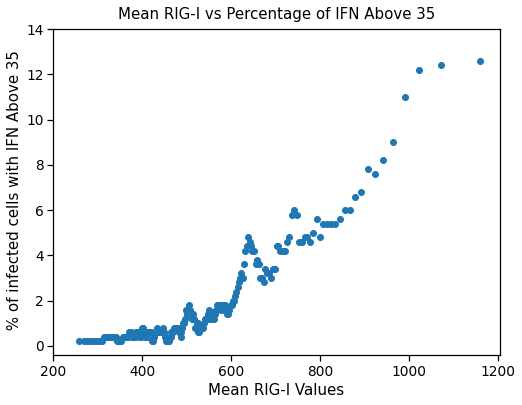

In [41]:
result_df_rux = process_and_plot_RUX(data_rux_6hpi, window_size=500, overlap_step=50, theta=35)

## 3b Removing outliers for IFN RUX

In [42]:
def remove_outliers_std_dev(df, column_name, threshold=2):
    """
    Remove outliers from a DataFrame using the standard deviation method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column in the DataFrame to identify outliers.
    - threshold (float): Z-score threshold for identifying outliers. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame without outliers.
    """

    # Calculate mean and standard deviation
    mean_value = df[column_name].mean()
    std_dev = df[column_name].std()

    # Calculate z-scores for each data point
    df['Z_Score'] = (df[column_name] - mean_value) / std_dev

    # Identify and remove outliers
    df_no_outliers = df[abs(df['Z_Score']) <= threshold].copy()

    # Drop the temporary Z_Score column
    df_no_outliers.drop(columns=['Z_Score'], inplace=True)

    return df_no_outliers

In [43]:
result_df_rux_no_outliners = remove_outliers_std_dev(result_df_rux, 'SD_norm', threshold=2)

## 3c Fitting experimental data for IFN RUX

In [52]:
def plotting_RUX_fit(virus, RIG_values, K3, n_NS1, K_NS1, theta):
    IFN_percent = result_df_rux_no_outliners["Percentage IFN Above Theta"].tolist()

    beta = 2
    v = virus
    v, R_tot = np.meshgrid(v, RIG_values)
    gamma = 30
    # 1. Calculation of active RIG-I protein concentration
    R_active = (v*R_tot)/(gamma+v)
    
    # 2. Calculation of IFN (or IRF3) concentration
    n = 5
    nv = 3
    K1 = 630
    K2 = 150
    beta = 2
    IRF3 = (R_active**n)/(K1**n + R_active**n)+((v**nv)/(K2**nv + v**nv))
    
    
    # 2b. Calculating IFN concentration
    alpha = 0.25
    beta = 12
    IFN = alpha*(IRF3**n)/(K3**n + IRF3**n)*beta*(1/(1+((v)/K_NS1)**n_NS1)) #the question is how to reduce the slope 
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_tot,v, R_active, cmap="Purples")
    ax.set_title('RIG-I*')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_tot,v, IRF3, cmap="Blues")
    ax.set_title('IRF3 expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    #Plotting IFN
    fig, ax = plt.subplots(figsize= (7,5))
    CS = ax.contourf(R_tot,v, IFN, cmap="Greens")
    ax.set_title('IFN expression')
    ax.set_xlabel('total RIG-I',labelpad=18)
    ax.set_ylabel('virus',labelpad=18)
    plt.colorbar(CS)
    
    
    # 3. Setting a thershold for IFN_active and calculating percentage
    fraction_of_cells = []
    for i in range(len(R_tot)):
        cells = IFN[i]   
        count = 0
        for element in cells:
            if element >= theta:
                count +=1
        fraction_of_cells.append((count/len(R_tot))*100) #check if this is correct
        
    
    plt.figure(figsize = (7,5))
    plt.plot(RIG_values,IFN_percent, "ok", label= "Experimental data")
    plt.plot(RIG_values,fraction_of_cells, 'or-', label= "Fitting")
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IFN")
    plt.legend()
    plt.savefig('IFN_RUX_fitting.pdf')
    
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))
    # Plot data on subplots
    ax1.plot(R_tot,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(R_tot,fraction_of_cells, 'or-', label= "Fitting")

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IFN')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Fitting")
    #plt.savefig('IFN_RUX_fitting.pdf')
    
    
    the_indices = np.arange(0, len(RIG_values), 5)
    plt.figure(figsize = (7,5))
    plt.plot(RIG_values,IFN_percent, "ok", label= "Experimental data")
    plt.plot(np.array(RIG_values)[the_indices],np.array(fraction_of_cells)[the_indices], 'r', label= "Fitting", linewidth=3)
    plt.xlabel("RIG-I protein (a.u.)")
    plt.ylabel("% of cells with IRF3")
    plt.legend()
    
    plt.figure(figsize = (10,5))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))

    # Plot data on subplots
    ax1.plot(RIG_values,IFN_percent, "ok", label= "Experimental data")
    ax2.plot(np.array(RIG_values)[the_indices],np.array(fraction_of_cells)[the_indices], 'r-', label= "Fitting" , linewidth = 3)

    # Set labels
    ax1.set_xlabel('RIG-I protein (a.u.)')
    ax1.set_ylabel('% of cells with IRF3')
    ax2.set_xlabel('RIG-I protein (a.u.)')

    # Set title
    ax1.set_title('Experimental data')
    ax2.set_title("Model behaviour")
    #plt.savefig('IRF3_fitting.pdf')

    plt.show()
    return fraction_of_cells,virus, IRF3

In [53]:
virus_RUX = [185,
 137,
 265,
 59,
 182,
 155,
 62,
 242,
 418,
 442,
 85,
 83,
 394,
 79,
 435,
 115,
 40,
 510,
 134,
 360,
 32,
 113,
 46,
 451,
 493,
 408,
 679,
 61,
 567,
 16,
 781,
 31,
 44,
 212,
 76,
 131,
 846,
 137,
 111,
 88,
 79,
 20,
 49,
 291,
 495,
 583,
 72,
 512,
 19,
 623,
 104,
 783,
 15,
 96,
 45,
 73,
 117,
 95,
 84,
 715,
 574,
 816,
 263,
 70,
 152,
 698,
 421,
 91,
 195,
 60,
 346,
 616,
 195,
 109,
 74,
 111,
 208,
 116,
 660,
 67,
 585,
 506,
 71,
 724,
 350,
 134,
 241,
 182,
 176,
 76,
 720,
 74,
 92,
 100,
 274,
 939,
 85,
 258,
 836,
 269,
 100,
 114,
 74,
 69,
 393,
 467,
 55,
 56,
 28,
 726,
 237,
 100,
 207,
 82,
 304,
 156,
 186,
 145,
 354,
 116,
 136,
 116,
 102,
 120,
 86,
 95,
 177,
 37,
 425,
 75,
 639,
 135,
 62,
 40,
 93,
 180,
 128,
 212,
 37,
 89,
 477,
 97,
 376,
 516,
 30,
 396,
 109,
 85,
 212,
 107,
 951,
 664,
 784,
 477,
 573,
 119,
 254,
 77,
 125,
 82,
 19,
 70,
 160,
 13,
 422,
 170,
 61,
 122,
 24,
 537,
 448,
 51,
 64,
 111,
 931,
 282,
 165,
 97,
 122,
 74,
 535,
 427,
 312,
 209,
 82,
 559,
 43,
 84,
 297,
 81,
 547]

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190]


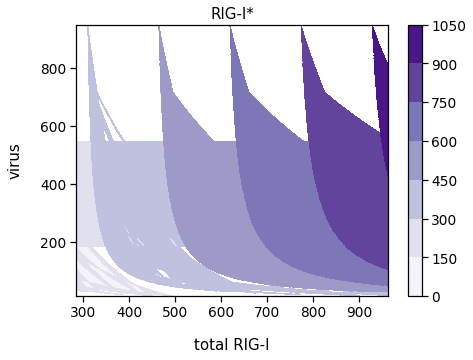

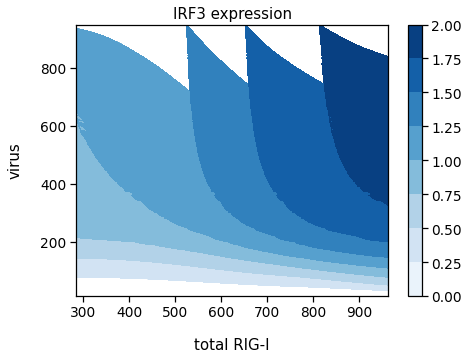

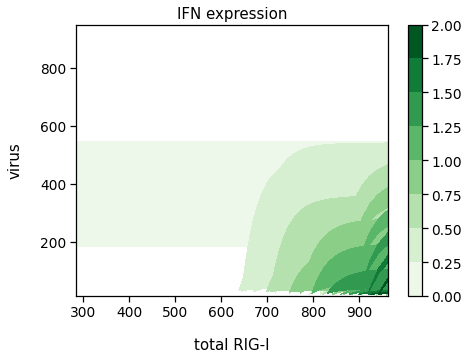

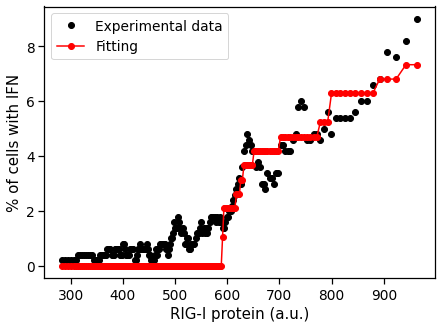

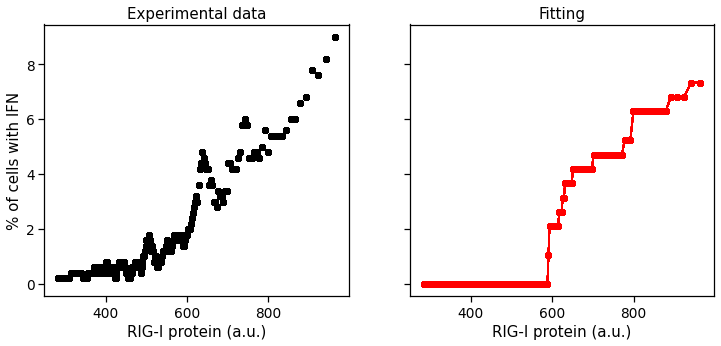

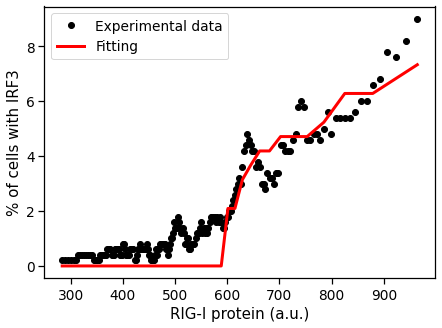

<Figure size 720x360 with 0 Axes>

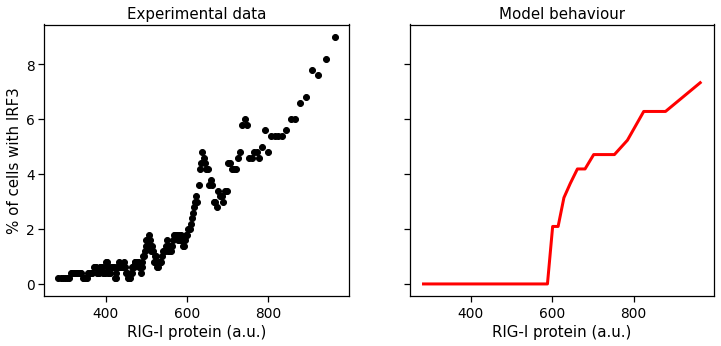

In [54]:
RIG_values = result_df_rux_no_outliners["Mean RIG-I"].tolist() 
actual_IFN_percentage = result_df_rux_no_outliners["Percentage IFN Above Theta"].tolist()
fraction_of_cells,virus,IRF3 = plotting_RUX_fit(virus_RUX, RIG_values, K3 = 0.05 , n_NS1 = 5, K_NS1 = 24, theta = 0.16) 